# Upper triangularization algorithm experimental notebook

In [1]:
import numpy as np
from math import factorial, comb
from numpy import polynomial as Polynomial
import matplotlib.pyplot as plt
import time
import random
from polynomial_utils import compose, compose_layers, l2_norm, l2_coefficient_norm, plot_polynomials, carleman, carleman_matrix
from tqdm import tqdm

In [2]:
def carleman_solver(h, g, target_poly: Polynomial, iteration: int = 10, size: int = 10, verbose=False):
    target_carleman = carleman_matrix(target_poly, size, 4)
    if verbose:
        print(f"g: {g}")
        print(f"h: {h}")
    for i in range(iteration):

        m_h = carleman_matrix(h, 4, 10).T

        g = Polynomial.Polynomial(np.linalg.lstsq(
            m_h, target_poly.coef, rcond=None)[0])

        m_g = carleman_matrix(g, size)
        m_g_inv = np.linalg.pinv(m_g)

        h = Polynomial.Polynomial([m_g_inv[1] @ target_carleman[:, j]
                                   for j in range(4)])

        if verbose:
            print(f"g: {g}")
            print(f"h: {h}")

            composed = compose_layers([h, g])
            plot_polynomials(composed, target_poly, i, linspace_range=(0, 1))

    if verbose:
        print()
    return h, g

In [3]:
def solve_for_h(g, target_poly):
    # Find shift variable d
    h0_poly = g - target_poly.coef[0]
    roots = h0_poly.roots()
    real_roots = [root.real for root in roots if np.isreal(root)]
    if len(real_roots) == 0:
        raise ValueError("No real roots found")
    
    # d = min(real_roots, key=abs)

    solutions = []
    for d in real_roots:
        
        # Shift g
        shifted_g0 = g(d) - d
        shifted_gl = []
        for l in range(1, g.coef.size):
            shifted_gl.append(sum([g.coef[j] * d**(j-l) * comb(j, l) for j in range(l, g.coef.size)]))
        shifted_g = Polynomial.Polynomial([shifted_g0] + shifted_gl)  # satisfies g(x+d)-d = shifted_g(x)

        # turns out this doesn't use q[0] so we can just use target_poly instead of shifted_q
        h1 = target_poly.coef[1] / shifted_g.coef[1]
        h2 = (target_poly.coef[2] - shifted_g.coef[2] * h1**2) / shifted_g.coef[1]
        h3 = (target_poly.coef[3] - shifted_g.coef[3] * h1**3 - shifted_g.coef[2] * 2 * h1 * h2) / shifted_g.coef[1]
        h = Polynomial.Polynomial([d, h1, h2, h3])

        solutions.append(h)
    # Is there a better way to choose the best h?

    # print(np.argmin(np.abs(real_roots)), np.argmin([l2_coefficient_norm(compose(g, h), target_poly) for h in solutions]))
    # print(real_roots)
    # print([l2_coefficient_norm(compose(g, h), target_poly) for h in solutions])
    # print()
    h = min(solutions, key=lambda h: l2_coefficient_norm(compose(g, h), target_poly))
    return h

In [4]:
def carleman_upper_triangular_solver(h, g, target_poly: Polynomial, iteration: int = 10, size: int = 10, w=None, verbose=False):
    if verbose:
        print(f"g: {g}")
        print(f"h: {h}")
    for i in range(iteration):
        m_h = carleman_matrix(h, 4, 10).T

        g = Polynomial.Polynomial(np.linalg.lstsq(
            m_h, target_poly.coef, rcond=None)[0])

        if verbose:
            composed = compose_layers([h, g])
            plot_polynomials(composed, target_poly, i+0.5)

        h = solve_for_h(g, target_poly)

        if verbose:
            print(f"g: {g}")
            print(f"h: {h}")

            composed = compose(g, h)
            plot_polynomials(composed, target_poly, i, linspace_range=(0, 1))

    if verbose:
        print()
    return h, g

In [5]:
def new_poly(width):
    p1 = Polynomial.Polynomial(np.random.uniform(-width, width, 4))
    p2 = Polynomial.Polynomial(np.random.uniform(-width, width, 4))
    target_poly = compose(p1, p2)
    return p1, p2, target_poly

In [6]:
g, h, target_poly = new_poly(1.5)
h_hat = solve_for_h(g, target_poly)
print(h)
print(h_hat)
print(l2_coefficient_norm(h, h_hat))

1.44758011 + 0.84179821·x + 1.31313245·x² + 0.54286151·x³
1.44758011 + 0.84179821·x + 1.31313245·x² + 0.54286151·x³
8.15843973306311e-16


100%|██████████| 10000/10000 [00:12<00:00, 828.25it/s]


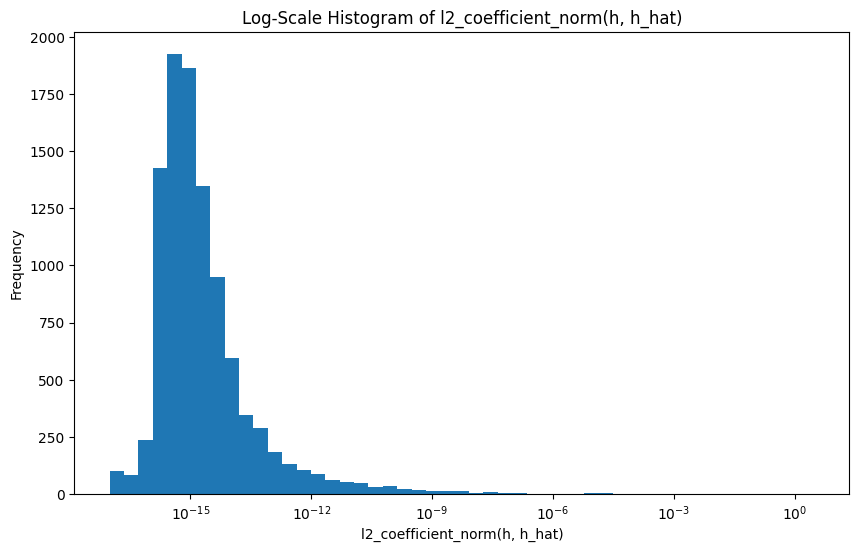

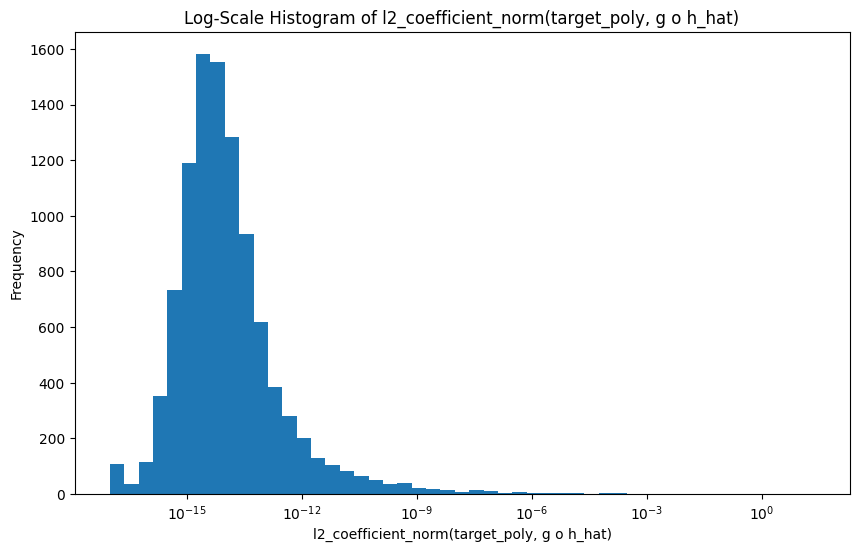

In [7]:
# Generate 1000 g, h, target_poly triplets
triplets = [new_poly(1.5) for _ in range(10000)]

# Calculate l2_coefficient_norm for each triplet
norms = []
target_norms = []
for g, h, target_poly in tqdm(triplets):
    h_hat = solve_for_h(g, target_poly)
    norm = l2_coefficient_norm(h, h_hat)
    norms.append(norm)
    target_norms.append(l2_coefficient_norm(target_poly, compose(g, h_hat)))

norms = np.array(norms) + 1e-17  # Add a small value to avoid log(0)
target_norms = np.array(target_norms) + 1e-17  # Add a small value to avoid log(0)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(norms, bins=np.logspace(np.log10(min(norms)), np.log10(max(norms)), 50))
plt.xscale('log')
plt.xlabel('l2_coefficient_norm(h, h_hat)')
plt.ylabel('Frequency')
plt.title('Log-Scale Histogram of l2_coefficient_norm(h, h_hat)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(target_norms, bins=np.logspace(np.log10(min(target_norms)), np.log10(max(target_norms)), 50))
plt.xscale('log')
plt.xlabel('l2_coefficient_norm(target_poly, g o h_hat)')
plt.ylabel('Frequency')
plt.title('Log-Scale Histogram of l2_coefficient_norm(target_poly, g o h_hat)')
plt.show()